In [80]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

np.random.seed(0)

def Calculate_Temperature(vel,N):
    real_vel = vel.copy()
    v_squared = np.sum(real_vel*real_vel, axis=1)
    v_mean = np.mean(v_squared)
    ene_kin_aver = 0.5*v_mean
    temperature = ene_kin_aver/3
    return ene_kin_aver,temperature


def compute_force(x):
    rm = 2.5
    n = x.shape[0]
    a = np.zeros(x.shape)
    energy_pot = np.zeros(x.shape)
    x0 = x[:,0]
    x1 = x[:,1]
    r_vec0 = x0.reshape((-1,1)) - x0
    r_vec1 = x1.reshape((-1,1)) - x1
    r_vec0[np.where(np.abs(r_vec0) > 10)] -= 20*np.sign(r_vec0[np.where(np.abs(r_vec0) > 10)])
    r_vec1[np.where(np.abs(r_vec1) > 10)] -= 20*np.sign(r_vec1[np.where(np.abs(r_vec1) > 10)])
    r = np.sqrt((r_vec0**2 + r_vec1**2+0.001))
    phi = (rm/r)**12 - 2*(rm/r)**6
    dphi = 12*rm**12/r**14 - 12*rm**6/r**8
    di = np.diag_indices_from(dphi)
    dphi[di] = 0
    phi[di] = 0
    a[:,0] = np.sum(dphi*r_vec0, axis=0)
    a[:,1] = np.sum(dphi*r_vec1, axis=0)
    return -2*a, np.sum(phi)/n


def solve_nbody(x, v, mu, dt, steps, method):
    n = x.shape[0]
    traj = np.zeros((steps, n, 2))
    temps = np.zeros(steps)
    energy_kin = np.zeros(steps)
    energy_pot = np.zeros(steps)
    
    for s in range(steps):
        for i in range(2):
            period = np.where(x[:,i] > 10)
            x[period,i]=x[period,i]-20
            period = np.where(x[:,i] < -10)
            x[period,i]=x[period,i]+20
        if method=="Leapfrog":
            x_half = x + v*dt/2
            a, energy_pot[s] = compute_force(x_half)
            energy_kin[s],temps[s] = Calculate_Temperature(v, n)
            v = v + (a - mu*v)*dt 
            x = x_half + dt/2*v 
        if method=="Euler":
            x = x + v*dt
            a, energy_pot[s] = compute_force(x)
            energy_kin[s],temps[s] = Calculate_Temperature(v, n)
            v = v + a*dt
        traj[s] = x
    return traj, energy_kin, energy_pot, temps

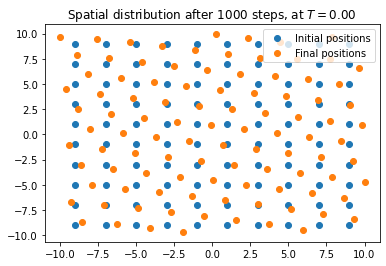

In [81]:
n = 10**2
mu = 1.0
dt = 0.01
steps = 1000
boxsize = 10

lin = np.linspace(-9,9,int(np.sqrt(n)))
X,Y = np.meshgrid(lin,lin)

x = np.vstack([X.ravel(), Y.ravel()]).T  
v = np.random.normal(0,1.0,(n,2))

traj, energy_kin, energy_pot, temps = solve_nbody(x, v, mu, dt, steps, "Leapfrog")

plt.plot(x[:,0], x[:,1], "o", label="Initial positions")
plt.plot(traj[-1,:,0], traj[-1,:,1],"o", label="Final positions")
plt.title("Spatial distribution after {} steps, at $T=${:.2f}".format(steps, temps[-1]))
plt.legend()

MovieWriter imagemagick unavailable; using Pillow instead.


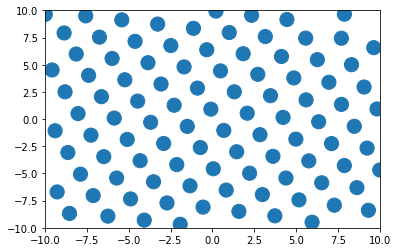

In [82]:
fig = plt.figure()
ax = plt.axes(xlim=(-10, 10), ylim=(-10, 10))

n = 10
v = np.random.normal(0,1,(n,2))
x = np.random.uniform(0,10,(n,2))

line = ax.scatter(traj[0,:,0], traj[0,:,1], s=np.ones(traj[0,:,0].shape)*200)

dt = 0.01
def init():
    line.set_offsets(np.c_[x[:,0], x[:,1]])
    return line,
def animate(i):
    x = traj[i]
    line.set_offsets(np.c_[x[:,0], x[:,1]])
    return line,

anim = FuncAnimation(fig, animate, frames=1000, interval=20)
anim.save('lennard_jones_cooling3.gif',writer='imagemagick') 